# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import os
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(170, 16, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "./data/faces/training/"
    training_dir1 = "./data/faces/training1/"
    testing_dir = "./data/faces/testing/"
    train_batch_size =32
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
    
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

folder_dataset1 = dset.ImageFolder(root=Config.testing_dir)

In [65]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      #transforms.CenterCrop(224),
                                                                      #transforms.RandomRotation(30, center=(0, 0)),
                                                                      #transforms.RandomHorizontalFlip(),
                                                                      transforms.ToTensor(),
                                                                      #transforms.Normalize((0.1307,), (0.3081)),
                                                                      
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

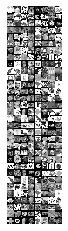

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [71]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=128)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [77]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
          
         


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
         


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*224*224, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 10),
            #nn.ReLU(inplace=True),

            nn.Linear(10, 2))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [78]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [90]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=48
                         )

In [91]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

In [92]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
import time

for epoch in range(0,Config.train_number_epochs):
    start = time.time()
    start_epoch = time.time()
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        #img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        
        accuracy = []
        for idx, logit in enumerate([output1, output2]):
            corrects=wrong=0
            print(torch.max(logit,1)[1].data)
            print(label.data)
            print(len(torch.max(logit,1)[1].data))
            for i in range(len(torch.max(logit,1)[1].data)):
                if torch.max(logit,1)[1].data[i] == label.long().data[i]:
                    corrects=corrects+1
                else:
                    wrong=wrong+1
                i=i+1
                    
#             corrects = (torch.max(logit,1)[1].data == label.long().data).sum()
#             wrong = (torch.max(logit, 1)[1].data != label.long().data).sum()
            print(corrects,wrong)
            accu = float(corrects) / float(len(torch.max(logit,1)[1].data))
#             accu = float(corrects) / float(label.size()[0])
            print(accu)
            accuracy.append(accu)
#         if i % 32 == 0:
#                 end = time.time()
#                 took = end - start
#                 for idx, accu in enumerate(accuracy):
#                     print('Train Epoch: {} \tTook: {:.2f}\tOut: {}\tAccu: {:.2f}'.format(
#                         epoch,
#                         took, i, accu * 100.))
# #         if i %10== 0 :
# #             print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
# #             iteration_number +=10
# #             counter.append(iteration_number)
# #             loss_history.append(loss_contrastive.item())
#        #torch.save(net.state_dict(), './net1.pkl')
# fig=plt.gcf()
# show_plot(counter,loss_history)
# fig.savefig("train1-1.png")

tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]])
48
18 30
0.375
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 

        [0.]])
48
28 20
0.5833333333333334
tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0])
tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]])
48
24 24
0.5
tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1

        [1.]])
48
25 23
0.5208333333333334
tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1])
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.]])
48
25 23
0.5208333333333334
tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1

        [0.]])
48
22 26
0.4583333333333333
tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]])
48
20 28
0.4166666666666667
tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0

        [1.]])
48
24 24
0.5
tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0])
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
48
21 27
0.4375
tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0

        [1.]])
48
27 21
0.5625
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])
48
20 28
0.4166666666666667
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0

        [1.]])
48
23 25
0.4791666666666667
tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])
48
21 27
0.4375
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0

        [0.]])
48
30 18
0.625
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
48
23 25
0.4791666666666667
tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 1,

        [1.]])
48
27 21
0.5625
tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]])
48
21 27
0.4375
tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1

        [1.]])
48
22 26
0.4583333333333333
tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0])
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.]])
48
28 20
0.5833333333333334
tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0

        [0.]])
48
20 28
0.4166666666666667
tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0])
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]])
48
25 23
0.5208333333333334
tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 1

['3', 'B']
{'3': 0, 'B': 1}
[('./data/faces/testing/3\\虫-蛉-1.jpg', 0), ('./data/faces/testing/3\\虫-蛉.jpg', 0), ('./data/faces/testing/B\\1 (1).jpg', 1), ('./data/faces/testing/B\\1 (2).jpg', 1), ('./data/faces/testing/B\\1 (3).jpg', 1), ('./data/faces/testing/B\\1 (4).jpg', 1)]
6
2
0 2


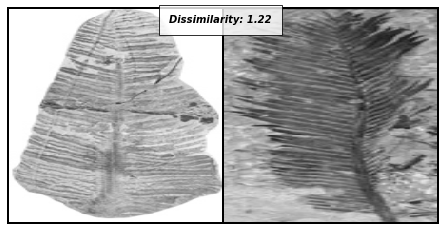

1
0 3
0 3


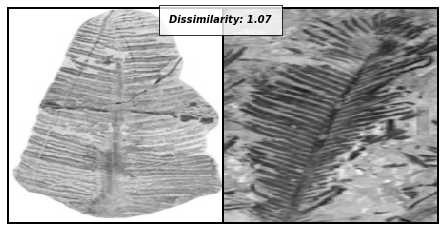

2
0 4
0 4


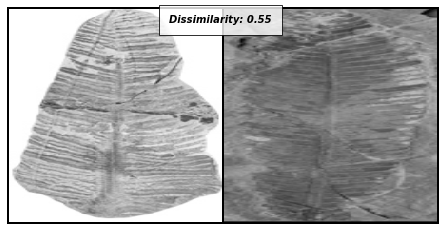

3
0 5
0 5


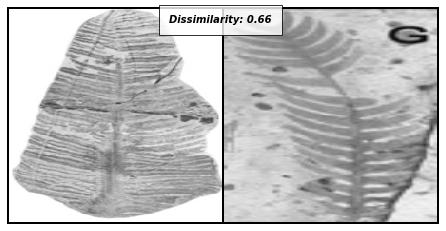

4
0 6
1 2


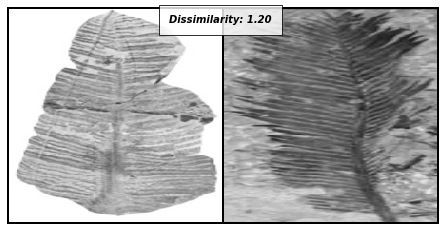

5
1 3
1 3


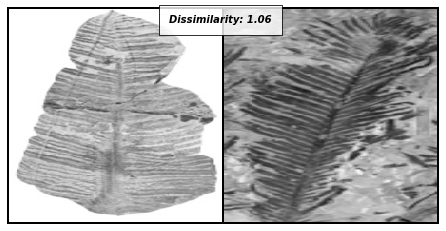

6
1 4
1 4


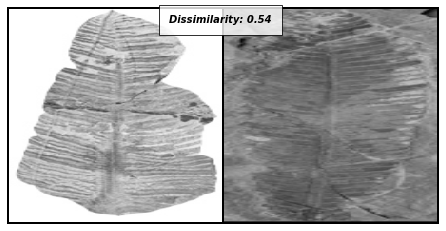

7
1 5
1 5


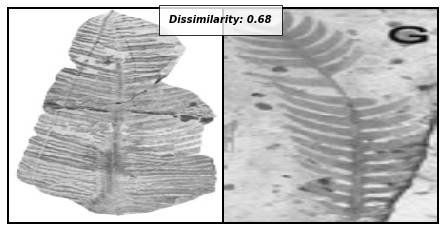

8
1 6


In [32]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os 
i=0
k=0
m=0
transform=transforms.Compose([transforms.Resize((224,224)),
                              transforms.ToTensor(),
                             ])
dataset=ImageFolder(Config.testing_dir)
print(dataset.classes)  #根据分的文件夹的名字来确定的类别
print(dataset.class_to_idx) #按顺序为这些类别定义索引为0,1...
print(dataset.imgs) #返回从所有文件夹中得到的图片的路径以及其类别
print(len(dataset.imgs))
net=SiameseNetwork()
# load params
pretrained_dict = torch.load('net.pkl')

# 获取当前网络的dict
net_state_dict = net.state_dict()

# 剔除不匹配的权值参数
pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if k in net_state_dict}

# 更新新模型参数字典
net_state_dict.update(pretrained_dict_1)

# 将包含预训练模型参数的字典"放"到新模型中
net.load_state_dict(net_state_dict)
net.eval()
#outfile=os.path.join("C:/Users/Administrator/Desktop/image/",))
     
while dataset[k][1]==0:
    k=k+1
print(k)
while i<=k-1:
    while dataset[i][1]==0:
        j=k
        x0=dataset.imgs[i]
        x0=Image.open(x0[0])
        x0=x0.convert("L")
        x0=transform(x0)
        x0=torch.unsqueeze(x0, 0)
        while dataset[j][1]==1:
            print(i,j)
            x1=dataset.imgs[j]
            x1=Image.open(x1[0])
            x1=x1.convert("L")
            x1=transform(x1)
            x1=torch.unsqueeze(x1, 0)
            concatenated = torch.cat((x0,x1),0)
            output1,output2 = net(Variable(x0),Variable(x1))
            euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
            fig=plt.gcf()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
            plt.margins(0,0)
            #fig.set_size_inches(3,10.0/3)
            imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
            filename = 'result-f5.txt'
            with open(filename,'a',encoding='utf-8') as f:
                f.writelines(str(euclidean_distance.item())+ ',' + '\n')
            fig.savefig(os.path.join("./result-f7",str(m)+".png"),dpi=200)
            m=m+1
            j=j+1
            print(m)
            print(i,j)
            if j>len(dataset.imgs)-1:
                break
        i=i+1         

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

tensor([[[[0.4078, 0.3725, 0.4667,  ..., 0.8392, 0.8392, 0.8275],
          [0.3686, 0.3569, 0.3961,  ..., 0.8431, 0.8431, 0.8431],
          [0.4941, 0.3216, 0.3451,  ..., 0.8471, 0.8510, 0.8471],
          ...,
          [0.6549, 0.5216, 0.4667,  ..., 0.4745, 0.4471, 0.4941],
          [0.5647, 0.4431, 0.4078,  ..., 0.5294, 0.5255, 0.5765],
          [0.5059, 0.3843, 0.3804,  ..., 0.5529, 0.5412, 0.5451]]]])
tensor([[[[0.7059, 0.7059, 0.7098,  ..., 0.5490, 0.5255, 0.5451],
          [0.7020, 0.7098, 0.7137,  ..., 0.5373, 0.5373, 0.5490],
          [0.7020, 0.7020, 0.7098,  ..., 0.5137, 0.5255, 0.5412],
          ...,
          [0.7020, 0.7020, 0.7098,  ..., 0.1608, 0.1569, 0.1569],
          [0.7020, 0.7020, 0.7020,  ..., 0.1765, 0.1765, 0.1647],
          [0.7020, 0.6980, 0.6980,  ..., 0.2039, 0.2039, 0.1843]]]])
tensor([[3.0803, 0.0289]], grad_fn=<AddmmBackward>) tensor([[ 4.1627, -0.0096]], grad_fn=<AddmmBackward>)


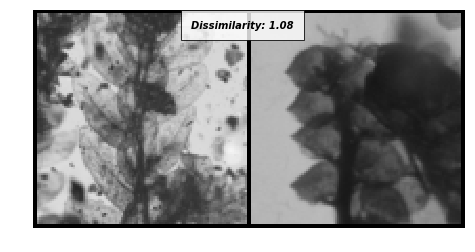

In [18]:

folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)
print(x0)

net=SiameseNetwork()
# load params
pretrained_dict = torch.load('net_fine1.pkl')

# 获取当前网络的dict
net_state_dict = net.state_dict()

# 剔除不匹配的权值参数
pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if k in net_state_dict}

# 更新新模型参数字典
net_state_dict.update(pretrained_dict_1)

# 将包含预训练模型参数的字典"放"到新模型中
net.load_state_dict(net_state_dict)
net.eval()
#outfile=os.path.join("C:/Users/Administrator/Desktop/image/",)
for i in range(1):
    _,x1,label2 = next(dataiter)
   
    print(x1)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0),Variable(x1))
    print(output1,output2 )
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
    fig=plt.gcf()
    #fig.set_size_inches(9,9)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

    plt.margins(0,0)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    fig.savefig("aa1.png")

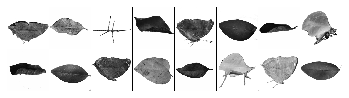

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]]
Epoch number 0
 Current loss 2.2499966621398926

Epoch number 1
 Current loss 1.9999971389770508

Epoch number 2
 Current loss 1.8749973773956299

Epoch number 3
 Current loss 1.8749973773956299

Epoch number 4
 Current loss 1.8749973773956299

Epoch number 5
 Current loss 2.2499966621398926

Epoch number 6
 Current loss 2.1874969005584717

Epoch number 7
 Current loss 1.7499974966049194

Epoch number 8
 Current loss 1.687497615814209

Epoch number 9
 Current loss 2.2499966621398926

Epoch number 10
 Current loss 1.9374971389770508

Epoch number 11
 Current loss 1.9999971389770508

Epoch number 12
 Current loss 2.3124966621398926



KeyboardInterrupt: 

In [22]:
folder_dataset = dset.ImageFolder("./data/faces/training1/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=64)
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


net=SiameseNetwork()
# load params
pretrained_dict = torch.load('net1.pkl')

# 获取当前网络的dict
net_state_dict = net.state_dict()

# 剔除不匹配的权值参数
pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if k in net_state_dict}

# 更新新模型参数字典
net_state_dict.update(pretrained_dict_1)

# 将包含预训练模型参数的字典"放"到新模型中
net.load_state_dict(net_state_dict)
optimizer = optim.Adam(net.parameters(),lr = 0.0005)
for epoch in range(0,30):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        #img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10== 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
torch.save(net.state_dict(), './net_fine1.pkl')            
fig=plt.gcf()
show_plot(counter,loss_history)
fig.savefig("train-fine1.png")